In [2]:
import numpy as np 
import uproot as ur
import matplotlib.pyplot as plt

import pickle

from bdt_utils import *
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler

# import xgboost as xgb
# from xgboost import plot_importance
# import shap
# from sklearn.inspection import permutation_importance


#from sklearn.utils import resample
#from utils import Logger, make_file_name, save_model, logloss_plot, auc_plot, aucpr_plot, roc_curve, pr_curve

In [3]:
class RareDecayBDTClassifier:
    def __init__(self,
                 model_params = None,
                 log_scaling = None,
                 normalization = None,
                 hyperparameters=None):
        ''''
        Initializing the default model with no scaling and normalization on the data
        (hyperparameters will be chosen later either by default or specified)
        '''

        ### TODO: maybe adding some of the default hyperparameters (what happen if we dont?)
        self.model_params = model_params or {'objective': 'binary:logitraw',
                                               'eval_metric': ['logloss', 'auc', 'aucpr'],
                                            #    'use_label_encoder': False,
                                               } # default metrices for the training optimization
                                                # not including hyperparameters
        self.log_scaling = log_scaling
        self.normalization = normalization
        self.scaler = StandardScaler()

        if hyperparameters:
            self.model_params.update(hyperparameters)

        # initializing thr BDT with hyperparameters
        self.model = XGBClassifier(**self.model_params)

    def transform_dataset(self, X):
        '''
        Transforming the dataset --> wheter to use log scaling, normalizaition, or both
        '''

        # TODO: investigate features that generally close to 0 --> might not need log-scale

        if self.log_scaling and self.normalization:
            # doing both log-scaling and normalization
            X = np.log(X+1e-8) # adding 1e-8 to prevent zero value  --> would this be a problem? (in case we really want 0 for some features)
            X = self.scaler.fit_transform(X)
            print('Log-Scaling and Normalization Done')

        elif self.normalization:
            # only normalization but not the log-scaling
            X = self.scaler.fit_transform(X)
            print('Normalization done without Log-scaling')

        elif self.log_scaling:
            # only the log-scaling but not the normalization
            X = np.log(X+1e-8)
            print('Log-scaling done without Normalization')

        else:
            print('no transformation was done!!!')

        return X # for later testing process in 'Evaluation'
    
    def fit(self, X_train, y_train, sample_weights=None):
        '''
        Fitting the model with X_train and y_train NOTE: The train/test split has to be done outside of class
        '''
        X_train = self.transform_dataset(X_train) # transforming the data
        self.model.fit(X_train, y_train, sample_weight=sample_weights)


    def predict(self, X):
        '''
        Predict between two classes: signal and background  
        '''
        return self.model.predict(X) # this will be the array  of label 0 or 1

    def predict_proba(self, X):
        '''
        Predict and getting the BDT score --> probability of class 1 == signal
        '''
        return self.model.predict_proba(X)[:, 1] # this will be the BDT score (associate with the probability)

    def evaluate(self, X_test, y_test, sample_weights=None):
        '''
        Evaluate the model performance
        '''
        # Transform the testing data if need
        X_test = self.transform_dataset(X_test)
        
        # using roc_auc_score as an accuracy score
        y_pred = self.predict_proba(X_test)
        # Evaluate scores
        roc_auc = roc_auc_score(y_test, y_pred, sample_weight=sample_weights)
        pr_auc = average_precision_score(y_test, y_pred)

        y_pred_labels = self.predict(X_test)
        f1 = f1_score(y_test, y_pred_labels, sample_weight=sample_weights)
        accu = accuracy_score(y_test, y_pred_labels, sample_weight=sample_weights)

        # return roc_auc_score(y_test, y_pred, sample_weight=sample_weights)
        return roc_auc, pr_auc, f1, accu

        # TODO: somehow to make ROC_AUC and PR_curve


    def save_model(self, path):
        '''
        Save the trained model using pickle
        '''
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print(f'Model saved to: {path}')

    @staticmethod
    def load_model(path):
        '''
        Load saved (trained model)
        '''
        with open(path, 'rb') as f:
            model = pickle.load(f)
        print(f'Model loaded from: {path}')
        return model

    # TODO
    # def hyperparams_tuning(self, param_grid, X_train, y_train, sample_weights=None, n_iter=20, n_jobs=-1, cv=5, verbose=1):

In [4]:
sig_file = 'train_sig_rare_lowQ_wPreselBDT_v6.root'
bkg_file = 'train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root'
features = ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
sample_weights = 'trig_wgt'
preselection = '(KLmassD0 > 2.) & ((Mll>1.05) & (Mll<2.45))'

# Loading dataset to check the dimension
signal, backgr, sig_weights, bkg_weights = sig_bkg_data_loading(sig_file, bkg_file, features, sample_weights, preselection)

print(f'Number of signal events: {signal.shape[1]}')
print(f'Number of background events: {backgr.shape[1]}')
print(f'Number of kinematic features: {signal.shape[0]}')

# splitting the data
X_train, X_test, y_train, y_test, weights_train, weights_test = prepare_combined_data(signal, backgr, sig_weights, bkg_weights)

# checkking the size of training and testing
print(f'Training sample size: {X_train.shape}')
print(f'Testing sample size: {X_test.shape}')

Number of signal events: 55039
Number of background events: 3593416
Number of kinematic features: 11
Training sample size: (2918764, 11)
Testing sample size: (729691, 11)


In [ ]:
# bdt = RareDecayBDTClassifier.load_model('rare_decay_bdt0.pkl')

Model loaded from: rare_decay_bdt0.pkl


In [ ]:
# hyperparameter
hyperparameters = {
    'n_estimators': 100,
    'max_depth': 9,
    'learning_rate': 0.35,
    'min_child_weight': 1.2,
    'gamma': 0.3,
    'scale_pos_weight': 0.5,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 7,
    'reg_lambda': 3,
}


# NO FEATURES TRANSFORMATION
 
# Initializing the BDT model
bdt = RareDecayBDTClassifier(log_scaling=None, normalization=None, hyperparameters=hyperparameters)
# Training
bdt.fit(X_train=X_train, y_train=y_train, sample_weights=weights_train)
# evaluate
roc_auc, pr_auc, f1, accuracy = bdt.evaluate(X_test, y_test, sample_weights=weights_test) # TODO: try returning y_pred for displays or making displays encapsulated
print(f'ROC AUC score: {roc_auc:.4f}')
print(f'PR AUC score: {pr_auc:.4f}')

no transformation was done!!!
no transformation was done!!!
ROC AUC score: 0.9941
PR AUC score: 0.8945


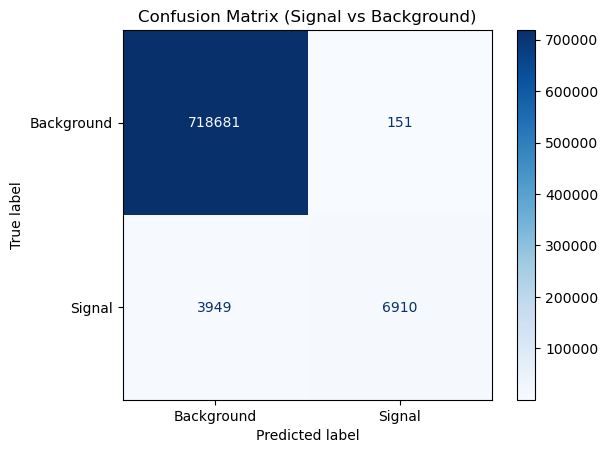

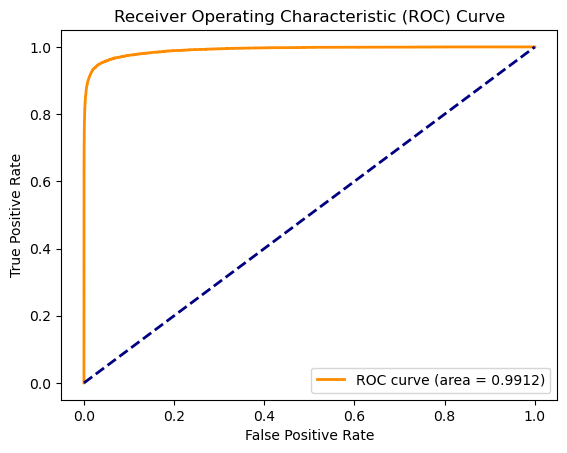

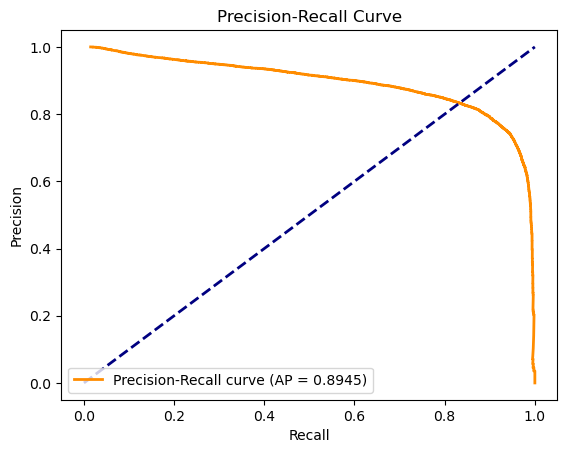

In [6]:
# getting y_pred for displays
y_pred = bdt.predict_proba(X_test) # TODO: might want to encapsulate this 
# y_pred = bdt.predict(X_test) # TODO: might want to encapsulate this 
# Displays
display_cf_matrix(y_test, y_pred, class_names=None, normalization=False)
display_roc_curve(y_test, y_pred)
display_pr_curve(y_test, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


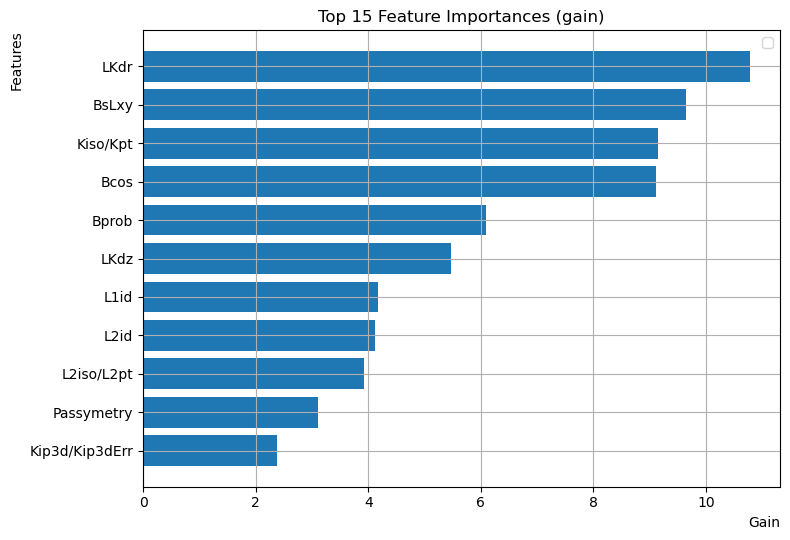

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


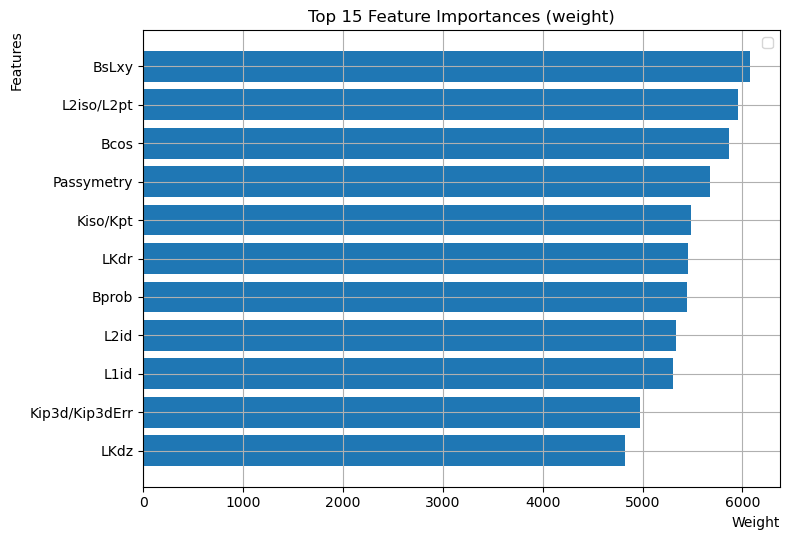

In [7]:
# Features Analyses
plot_features_importance(model=bdt.model,
                         feature_names=features,
                         importance_type='gain', # average gain --> imporvement in loss when features are used in the splits
                         max_num_features=15)
plot_features_importance(model=bdt.model,
                         feature_names=features,
                         importance_type='weight', # Number of times a feature is used to split the data across all trees
                         )

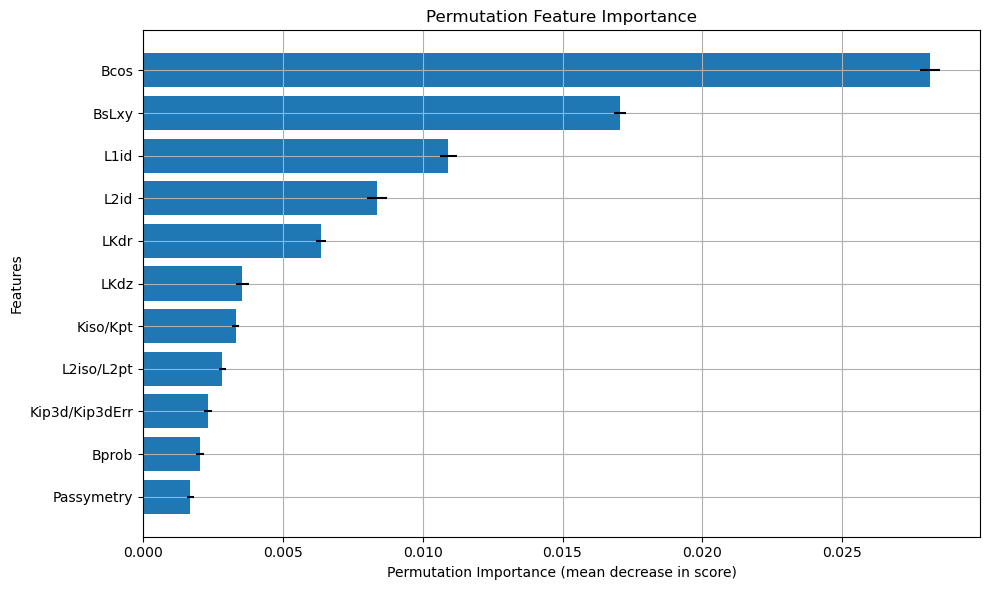

In [8]:
# permutation importance
plot_permutation_importance(model=bdt.model,
                            X=X_test,
                            y=y_test,
                            feature_names=features,
                            n_repeats=10,
                            scoring='roc_auc',
                            )

729691


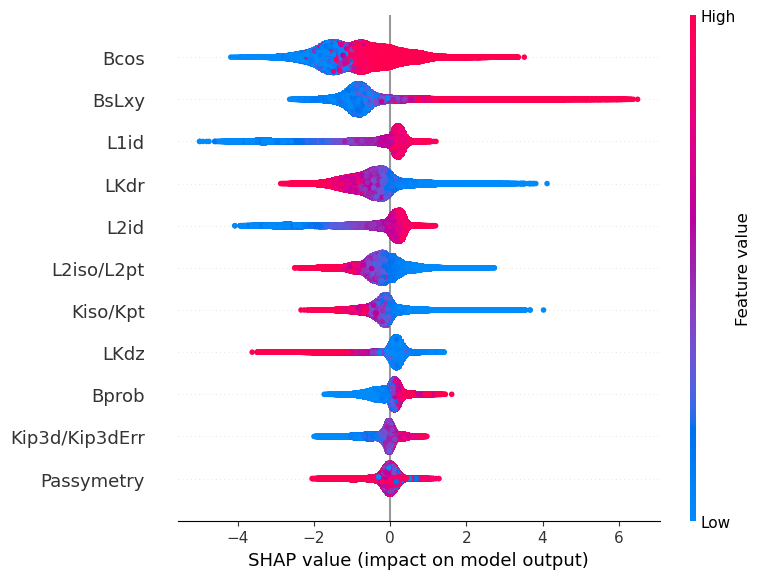

In [10]:
# # Sample a subset to speed up SHAP
size = int(1*X_test.shape[0])
print(size)
indices = np.random.choice(X_test.shape[0], size=size, replace=False)
X_sample = X_test[indices]   # adjust 100 as needed
shap_summary(model=bdt.model, X=X_sample, feature_names=features)

# # SHAP --> features' impact on the model predictive
# shap_summary(model=bdt.model, X=X_test, feature_names=features)

In [118]:
# Save trained model
bdt.save_model("rare_decay_bdt0.pkl")

Model saved to: rare_decay_bdt0.pkl


In [9]:
# hyperparameter
hyperparameters = {
    'n_estimators': 100,
    'max_depth': 9,
    'learning_rate': 0.35,
    'min_child_weight': 1.2,
    'gamma': 0.3,
    'scale_pos_weight': 0.5,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'num_parallel_tree': 7,
    'reg_lambda': 3,
}


# NORMALIZATION without log-scaling
# NOTE: BDT might not be sensitive for features transformation
 
# Initializing the BDT model
bdt = RareDecayBDTClassifier(log_scaling=False, normalization=True, hyperparameters=hyperparameters)
# Training
bdt.fit(X_train=X_train, y_train=y_train, sample_weights=weights_train)
# evaluate
roc_auc, pr_auc, f1, accuracy = bdt.evaluate(X_test, y_test, sample_weights=weights_test) # TODO: try returning y_pred for displays or making displays encapsulated
print(f'ROC AUC score: {roc_auc:.4f}')
print(f'PR AUC score: {pr_auc:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Accuracy score: {accuracy:.4f}')

Normalization done without Log-scaling
Normalization done without Log-scaling
ROC AUC score: 0.9929
PR AUC score: 0.8592
F1 score: 0.7623
Accuracy score: 0.9986


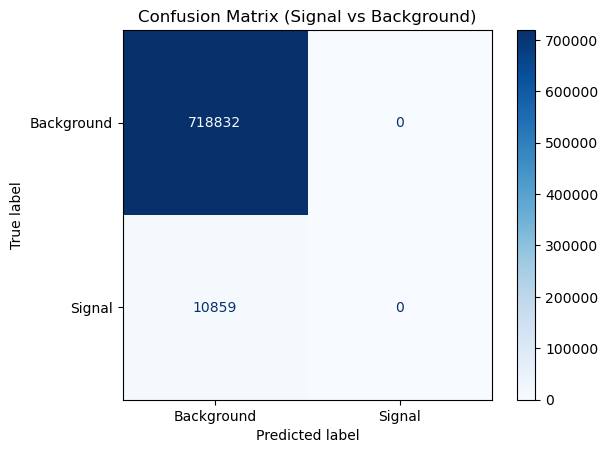

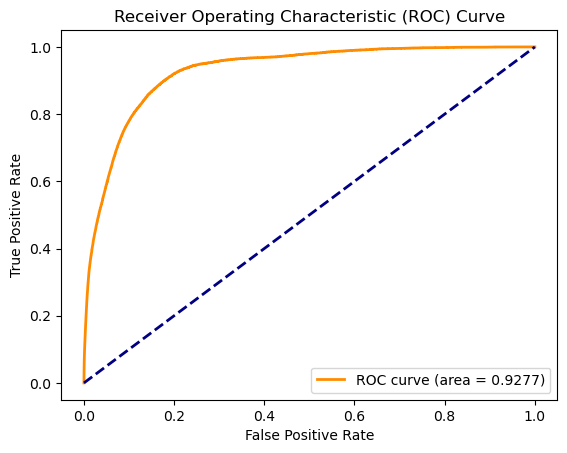

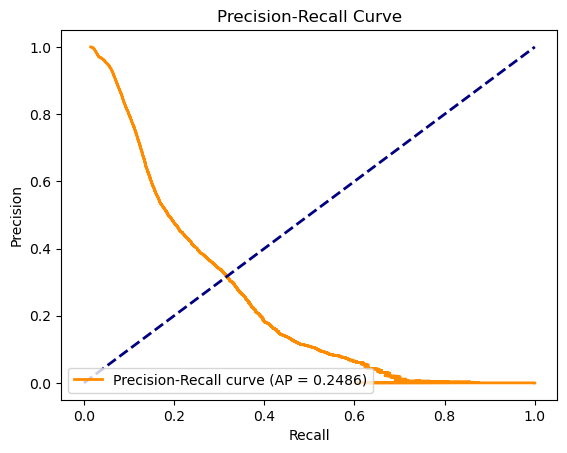

In [10]:
# getting y_pred for displays
y_pred = bdt.predict_proba(X_test) # TODO: might want to encapsulate this 
# y_pred = bdt.predict(X_test) # TODO: might want to encapsulate this 
# Displays
display_cf_matrix(y_test, y_pred, class_names=None, normalization=False)
display_roc_curve(y_test, y_pred)
display_pr_curve(y_test, y_pred)

In [11]:
# Save trained model
bdt.save_model("rare_decay_bdt1.pkl")

Model saved to: rare_decay_bdt1.pkl


In [12]:
# loading saved model
bdt = RareDecayBDTClassifier.load_model('rare_decay_bdt0.pkl')

# default evaluation
roc_auc, pr_auc, f1, accuracy = bdt.evaluate(X_test, y_test, sample_weights=weights_test) # TODO: try returning y_pred for displays or making displays encapsulated
print(f'ROC AUC score: {roc_auc:.4f}')
print(f'PR AUC score: {pr_auc:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Accuracy score: {accuracy:.4f}')

Model loaded from: rare_decay_bdt0.pkl
Something is wrong in Transform_dataset or no transformation was done!!!
ROC AUC score: 0.9941
PR AUC score: 0.8945
F1 score: 0.7921
Accuracy score: 0.9989


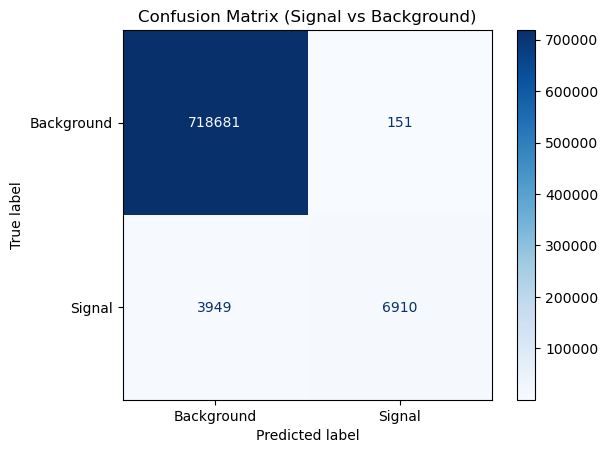

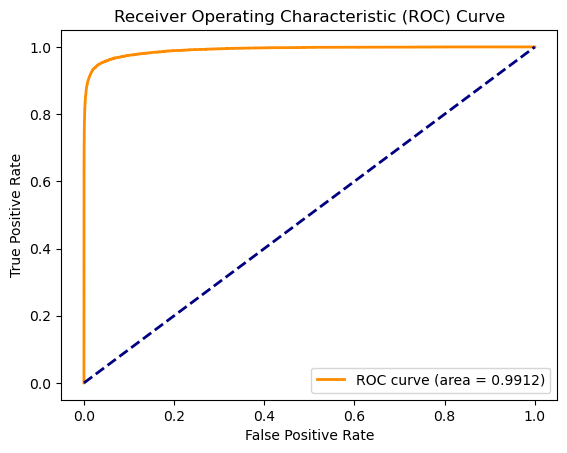

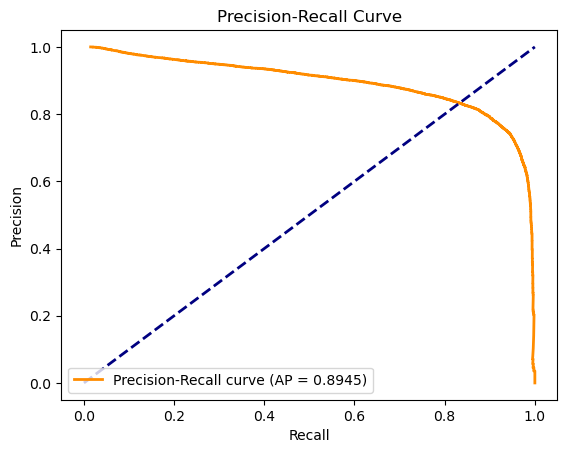

In [13]:
# getting y_pred for displays
y_pred = bdt.predict_proba(X_test) # TODO: might want to encapsulate this 
# y_pred = bdt.predict(X_test) # TODO: might want to encapsulate this 
# Displays
display_cf_matrix(y_test, y_pred, class_names=None, normalization=False)
display_roc_curve(y_test, y_pred)
display_pr_curve(y_test, y_pred)

In [ ]:
### TODO: comparing the performance wwhether using log-scaling, normalization, or both

In [ ]:
### TODO: hyperparameters for searching --> Tuning
param_grid = {
        #'n_estimator':[50,100,200],
        'max_depth':[9],
        'learning_rate':[0.35],
        'min_child_weight':[1.4],
        'gamma':[0.5],
        'scale_pos_weight':[0.7],
        'subsample':[0.85],
        'colsample_bytree':[0.7],
        #'early_stopping_rounds': [10,20,30],
        'num_parallel_tree':[8],
        'reg_lambda':[3]
}

In [ ]:
### TODO: Implementing the Cross-Validation and StratifiedKFold
# custom ROC and PR curves across folds

In [ ]:
# random_seed = 135
# sigfile = ur.open('train_sig_rare_lowQ_wPreselBDT_v6.root')
# bkgfile = ur.open('train_bkg_data_sideBands_lowQ_wPreselBDT_v5.root')

# features = ['Bprob', 'BsLxy', 'L2iso/L2pt', 'Bcos', 'Kiso/Kpt', 'LKdz', 'LKdr', 'Passymetry', 'Kip3d/Kip3dErr', 'L1id', 'L2id']
# sample_weights = 'trig_wgt'
# preselection = '(KLmassD0 > 2.) & ((Mll>1.05) & (Mll<2.45))'

# sig_dict = sigfile['mytree'].arrays(features, library='np', cut=preselection)
# bkg_dict = bkgfile['mytree'].arrays(features, library='np', cut=preselection)

# backgr = np.stack(list(bkg_dict.values()))
# signal = np.stack(list(sig_dict.values()))

# sig_weight = sigfile['mytree'].arrays(sample_weights, library='np', cut=preselection)[sample_weights]
# bkg_weight = np.ones(backgr.shape[1])

# X = np.transpose(np.concatenate((signal, backgr), axis=1))
# y = np.concatenate((np.ones(signal.shape[1]), np.zeros(backgr.shape[1])))
# weights = np.concatenate((sig_weight, bkg_weight))

In [ ]:
# X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.05, random_state=random_seed)
# eval_set = ((X_train, y_train), (X_test, y_test))

# # skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed) #shuffle effect?

# # # Old BDT
# # bdt_old = XGBClassifier(
# #         max_depth=6,
# #         n_estimators=300,
# #         learning_rate=0.1,
# #         min_child_weight=1.,
# #         gamma=3.,
# #         subsample=1.,
# #         scale_pos_weight=1.,
# #         objective='binary:logitraw',
# #         eval_metric=['logloss','auc','aucpr'],
# # )

# # # Train old bdt with same X_train/y_train/weights_train
# # bdt_old.fit(X_train, y_train, eval_set=eval_set,sample_weight=weights_train, verbose=2)